# Librerias y Datasets

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
# Se accede a Google Drive

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Se especifica el directorio de los datos de entrenamiento

XRayDirectory = "/content/drive/MyDrive/Colab Notebooks/Portafolio/Data/health/Dataset"

In [ ]:
# Se listan todas las carpetas del directorio

os.listdir(XRayDirectory)

['0', '1', '2', '3']

In [ ]:
# Se utiliza el generador de imágenes para generar datos de imágenes y normalizarlos
# y tambien se utiliza el 80% de los datos para entrenamiento, y, el 20% de los datos para la validación posterior

image_generator = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

In [ ]:
# Se definen los datos de entrenamiento a traves de  un flujo de cargue de imagenes
# con lotes de imagenes de 40 en 40, seleccinando muestras de manera aleatoria (shuffle = True)
# desde el directorio y con tamaños de imagenes de 256x256.
# En total son 532 imagenes

train_generator = image_generator.flow_from_directory(batch_size=40, directory=XRayDirectory, shuffle=True, 
                                                      target_size = (256,256), class_mode = 'categorical', subset = 'training' )
# 428 (80%) Imagenes para los datos de entrenamiento

Found 428 images belonging to 4 classes.


In [ ]:
# Se definen los datos de validación

test_generator = image_generator.flow_from_directory(batch_size=40, directory=XRayDirectory, shuffle=True, 
                                                      target_size = (256,256), class_mode = 'categorical', subset = 'validation')
# 104 (20%) Imagenes para los datos de validación

Found 104 images belonging to 4 classes.


In [ ]:
# Se genera un lote de 40 imágenes y etiquetas
train_images, train_labels = next(train_generator)

In [ ]:
train_images.shape

(40, 256, 256, 3)

In [ ]:
train_images

array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.40784317, 0.40784317, 0.40784317],
         [0.        , 0.        , 0.        ],
         [0.31764707, 0.31764707, 0.31764707]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.40000004, 0.40000004, 0.40000004],
         [0.40784317, 0.40784317, 0.40784317],
         [0.36078432, 0.36078432, 0.36078432]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.38431376, 0.38431376, 0.38431376],
         [0.31764707, 0.31764707, 0.31764707],
         [0.38431376, 0.38431376, 0.38431376]],

        ...,

        [[0.03529412, 0.03529412, 0.03529412],
         [0.        , 0.        , 0.        ]

In [ ]:
# Definición de cada etiqueta
label_names = {0:'COVID_19', 1:'Normal', 2:'Pneumonia Virica', 3:'Pneumonia Bacteriana'}

# Visualización de Imagenes

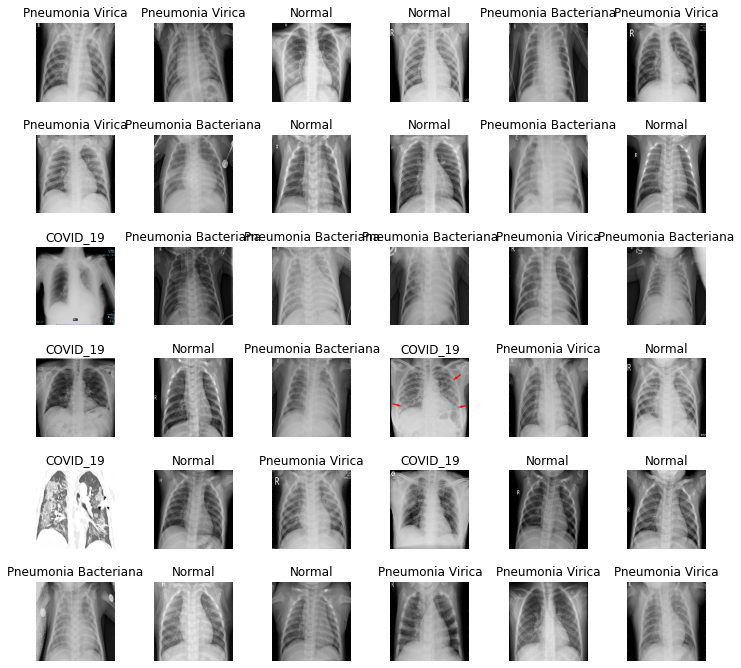

In [ ]:
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)

# Definición del modelo

In [ ]:
# Se define un modelo a partir de una Resnet
base_model = ResNet50(weights = "imagenet", include_top = False, input_tensor = Input(shape = (256, 256, 3)))

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
# Se congela el modelo anterior obtenido, excepto las ultimas 10 capas,
# que serán ajustadas a nuestro problema

for layer in base_model.layers[:-10]:
    layer.trainable = False

In [ ]:
# Se crea la arquitectura propia de nuestro modelo, ajustado
# al problema que intentamos resolver.

head_model = base_model.output
# head_model = AveragePooling2D(pool_size=(8,8))(head_model)
# Conv2D(filters = 32, kernel_size = (4,4), activation = 'relu')

head_model = Flatten(name = 'flatten')(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(128, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(64, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)

head_model = Dense(4, activation = 'softmax')(head_model)

# Se crea un modelo general compuesto por el modelo base de la Resnet
# y la arquitectura ajustada a nuestro problema
model = Model(inputs = base_model.input, outputs = head_model)

In [ ]:
# Compilación del modelo
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(learning_rate = 1e-4, decay = 1e-6), metrics = ["accuracy"])

In [ ]:
# Usar la parada temprana (early stopping) para salir del entrenamiento si la pérdida en la validación no disminuye incluso después de ciertas épocas (paciencia)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# Almacenar el mejor modelo con la menor pérdida en la validación
checkpointer = ModelCheckpoint(filepath = "weights.hdf5", verbose = 1, save_best_only=True)

In [ ]:
# Se define datos de entrenamiento y validación
train_generator = image_generator.flow_from_directory(batch_size=4, directory = XRayDirectory, shuffle = True, target_size=(256, 256), class_mode = "categorical", subset = "training")
val_generator = image_generator.flow_from_directory(batch_size=4, directory = XRayDirectory, shuffle = True, target_size=(256, 256), class_mode = "categorical", subset = "validation")

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [ ]:
# Entrenamiento del modelo

# history = model.fit(train_generator, steps_per_epoch=train_generator.n//4, epochs = 25, 
#                               validation_data = val_generator, validation_steps = val_generator.n // 4,
#                               callbacks = [checkpointer, earlystopping])
history = model.fit_generator(train_generator, epochs = 25, validation_data = val_generator, callbacks = [checkpointer, earlystopping])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
107/107 [==============================] - 21s 159ms/step - loss: 2.1270 - accuracy: 0.2850 - val_loss: 1.3263 - val_accuracy: 0.3077

Epoch 00001: val_loss improved from inf to 1.32626, saving model to weights.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
107/107 [==============================] - 16s 149ms/step - loss: 1.3639 - accuracy: 0.3598 - val_loss: 1.2091 - val_accuracy: 0.3846

Epoch 00002: val_loss improved from 1.32626 to 1.20905, saving model to weights.hdf5
Epoch 3/25
107/107 [==============================] - 16s 148ms/step - loss: 1.1762 - accuracy: 0.4603 - val_loss: 1.3836 - val_accuracy: 0.4038

Epoch 00003: val_loss did not improve from 1.20905
Epoch 4/25
107/107 [==============================] - 16s 148ms/step - loss: 1.1355 - accuracy: 0.4930 - val_loss: 1.0177 - val_accuracy: 0.5096

Epoch 00004: val_loss improved from 1.20905 to 1.01766, saving model to weights.hdf5
Epoch 5/25
107/107 [==============================] - 16s 147ms/step - loss: 1.0589 - accuracy: 0.5888 - val_loss: 1.6362 - val_accuracy: 0.3846

Epoch 00005: val_loss did not improve from 1.01766
Epoch 6/25
107/107 [==============================] - 16s 149ms/step - loss: 0.9683 - accuracy: 0.6075 - val_loss: 1.0565 - val_accuracy: 0.6346

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

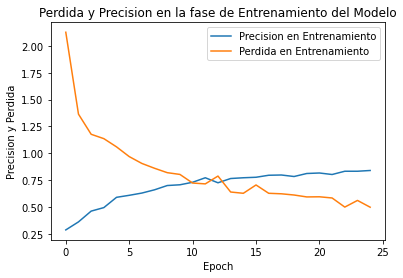

In [ ]:
# Grafica de precisión y perdida en Entrenamiento

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title("Perdida y Precision en la fase de Entrenamiento del Modelo")
plt.xlabel("Epoch")
plt.ylabel("Precision y Perdida")
plt.legend(["Precision en Entrenamiento", "Perdida en Entrenamiento"])

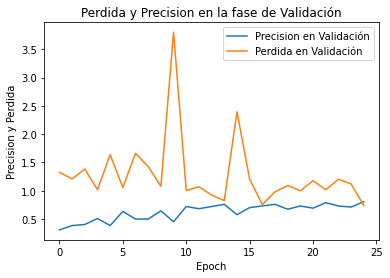

In [ ]:
# Grafica de precisión y perdida en Validación

plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])


plt.title("Perdida y Precision en la fase de Validación")
plt.xlabel("Epoch")
plt.ylabel("Precision y Perdida")
plt.legend(["Precision en Validación", "Perdida en Validación"])

In [ ]:
# Se carga el conjunto de datos para testear con imagenes que no se utilizaron en
# el modelo
test_directory = "/content/drive/MyDrive/Colab Notebooks/Portafolio/Data/health/Test"

In [ ]:
# Se define el flujo de datos para las imagenes de test y se evalua la precisón

test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size=40, directory=test_directory, shuffle=True, target_size=(256, 256), class_mode="categorical")

evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose = 1)

print("Precision en la fase de Test : {}".format(evaluate[1]))

Found 40 images belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


10/10 [==============================] - 1s 1ms/step - loss: 1.1232 - accuracy: 0.7000
Precision en la fase de Test : 0.699999988079071


In [ ]:
# Se construye un conjunto de imagenes de test con la etiqueta de predicción y
# su etiqueta original

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
    for item in os.listdir(os.path.join(test_directory, str(i))):
        img = cv2.imread(os.path.join(test_directory, str(i), item))
        img = cv2.resize(img, (256,256))
        image.append(img)
        img = img/255
        img = img.reshape(-1, 256, 256, 3)
        predict = model.predict(img)
        predict = np.argmax(predict)
        prediction.append(predict)
        original.append(i)

In [ ]:
# Se valida la eficacia de la predicción con las imagenes de test procesadas
score = accuracy_score(original, prediction)
print("Eficacia de la prediccion {}".format(score))

Eficacia de la prediccion 0.75


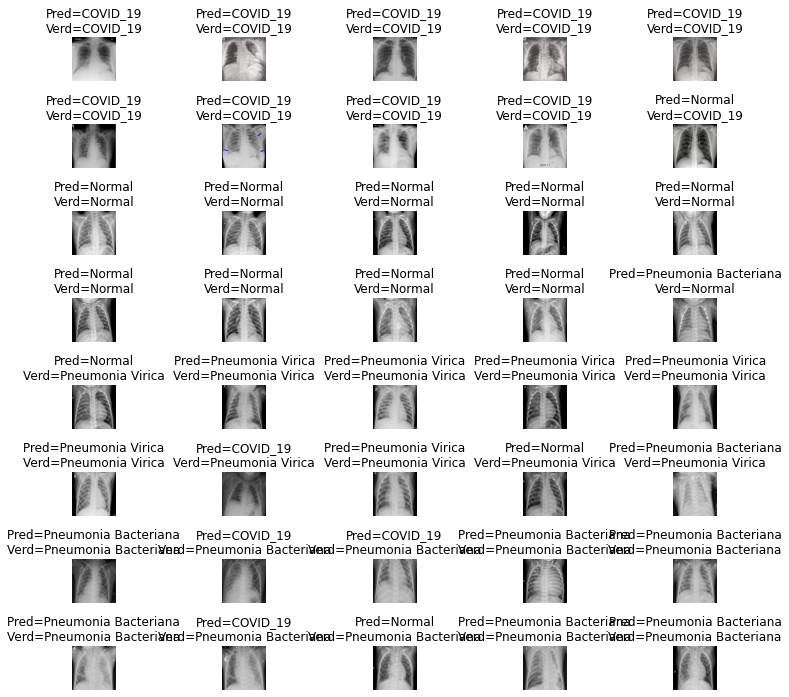

In [ ]:
# Se visualiza el conjunto de imagenes de test con la etiqueta de predicción y
# su etiqueta original

L = 8
W = 5

fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title("Pred={}\nVerd={}".format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2, hspace=1)

In [ ]:
# Se obtiene la metricas del modelo

print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.69      0.90      0.78        10
           1       0.69      0.90      0.78        10
           2       1.00      0.60      0.75        10
           3       0.75      0.60      0.67        10

    accuracy                           0.75        40
   macro avg       0.78      0.75      0.75        40
weighted avg       0.78      0.75      0.75        40



Text(0.5, 1.0, 'Matriz de Confusion')

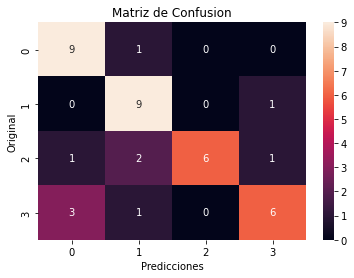

In [ ]:
# Se visualiza matriz de confusión

cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)
ax.set_xlabel("Predicciones")
ax.set_ylabel("Original")
ax.set_title("Matriz de Confusion")